# Hot Water Tank with Level Control

This Jupyter Notebook demonstrates the development of a process dynamics and control model for a hot water storage tank on a fictional chemical plant that utilises hot water for various process demands, such as washing, flushing and as part of product recipes.

## 1. Importing Relevant Packages

The Python script requires the relevant packages to be imported, to complete some of the calculations.


In [321]:
import numpy as np

import matplotlib.pyplot as plt

## 3. Definition of System Parameters

Second, the system needs to be defined geometrically by the diameter (D), height (H) and hence this allows us to calculate the volume (V).

The opportunity will also be taken to calculate the cross-sectional area of the vessel, for future use.

All system units are in SI units - i.e. metres, seconds, kg.

In [324]:
D = 5.0

H = 5.1

CSA = 0.25 * np.pi * D**2

Vmax = CSA * H

print('Tank has a volume of ' + str(round(Vmax,0)) + " m3.")

Tank has a volume of 100.0 m3.


## 4. Define the Initial Conditions of the System

Lets suppose that the tank starts out as empty, meaning that the initial level is zero %. We can calculate the volume of liquid in the tank at this initial condition, as below.

In [327]:
L0 = 0 # Defined in percentage terms, but decimalised.

V0 = L0 * CSA

print('Tank has an initial level of ' + str(round(V0,0)) + " m3.")

Tank has an initial level of 0.0 m3.


## 5. Establish the Governing Equations of the Tank Level

Fundamentally, the tank level, when subject to filling and emptying, is governed by a volume balance against time, assuming a constant density.

$$\frac{dV}{dt} = Q_1 - Q_2 $$

Whereby $V=$ volume in tank, $Q_1$= inlet flow rate, $Q_2$= outlet flow rate, $t$= time.

This differential equation fundamentally comes down to the traditional mass balance in chemical engineering of: "in - out = accumulation". There are no generation or consumption terms.

This particular differential equation is simple and can be integrated analytically.

The particular solution, parameterised by general conditions, becomes:

$$ V = V_0 + (Q_1 - Q_2)(t-t_0)$$

Whereby $V_0=$ initial volume and $t_0$= initial time. 

For the purposes of this modelling, the analytical equation cannot be used, since it assumes that $Q_1$ and $Q_2$ are constant with respect to time, which is not the vision for this system. We intend to introduce changes to $Q_1$ and/or $Q_2$ at different points in time.

## 6. Defining the System Behaviour - Flow Rates

With the two variables being $Q_1$ and $Q_2$, we need to decide how we want these to vary. Now it stands to reason that the filling rate, $Q_1$, might be constant, based on a reliable and consistent mains water supply. 

By contrast, depending on the number of downstream users, the outflow rate, $Q_2$, may vary.

We are going to define the inlet flow rate, as a constant, as per the below. The number inside the parentheses is in units of $m^3\ h^{-1}$, with the conversion to SI units ($m^3\ s^{-1}$) taking place outside of the parentheses.

We are going to permit $Q_1$ to take a value of zero, as well as the one defined below.

In [300]:
Qin = (15) / 3600

## 7. Defining the System Behaviour - Control Philosophy

By virtue of the tank being on level control, we want to define some type of control philosophy.

There are a couple of options, namely:

- On/off control; OR
- PID control.

On/off control is going to be used in this model and effectively means that the flow in, can either be 'on' or 'off', with no capacity to modulate. This mode of control will require us to define an upper and lower control point, with the 'space' in between being called a 'deadband'.

PID control would seek to maintain the level at a single constant value, albeit with some variance, depending on the PID tuning and outflow.

The control points for the on/off control are defined below. The values in the parentheses constitute the percentage level but decimalised.

In [334]:
Vupper = (0.8) * Vmax

Vlower = (0.2) * Vmax

print('The control points are between ' + str(round(Vlower/Vmax*100,0)) + ' % and '+ str(round(Vupper/Vmax*100,0)) + ' % of maximum working volume.')

The control points are between 20.0 % and 80.0 % of maximum working volume.


The two values chosen above are reasonable, with most hot water systems of this type perhaps being fitted with a high high level trip, lets say arbitrarily at 90 % level, the system 'trips' such that it cannot be overfilled.

## 8. Defining the Differential Equation Function for Level

We must make the differential equation into a function that can be called, as part of the iteratve loop, as the simulation runs.

In [305]:
def dVdt(Q1, Q2): 

    dVdt = Q1 - Q2
    
    return dVdt

## 9. Set up the Iterative Loop Parameters

Part of most iterative loops in programming require the definition of a time vector and empty arrays in which to store the iterated values.

Below shows the initial time, $t_0$, final time, $t_f$ and time step, $dt$ all defined. 

Below that is the definition of n_steps, which tells the empty arrays how large they need to be, based on the number of time steps to iterate.

The final time has been coded such that the number of days can be input to the first set of parentheses.

In [340]:
t0 = 0
tf = (7)*(24)*(3600)
dt = 1

n_steps = int(tf/ dt)+1

t = np.zeros(n_steps)
V = np.zeros(n_steps)

# Set initial values of the empty arrays, as per the defined initial volume and initial time.
t[0] = t0
V[0] = V0


## 10. Iterative Loop & Results

Below is the iterative loop for the solver, with a built-in deadband for the level control.

It iterates through the number of steps defined above and populates the time/volume vectors after each iteration. 

The upper and lower deadbands are defined in the first two sections of code, with two adjustments made to the emptying rate at configurable time values (e.g. 10 % of final time etc.).

The Euler method has been used to solve the differential equation, with a step size defined as $dt$ above. Other methods may include the 'Improve Euler' method, or Runge-Kutta methods of higher orders. Python's odeint function could be used also.

Some post-results processing then takes place to make the time units into a more convenient set of units, with the processed results then being plotted.

Text(0, 0.5, 'Volume [m3]')

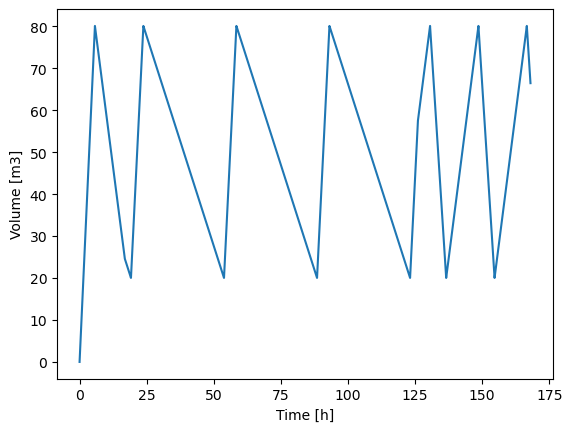

In [345]:
for i in range(1, n_steps):

    # Lower deadband
    if V[i-1] < Vlower:
        Q1 = Qin
        Q2 = (1)/3600

     # Upper deadband
    elif V[i-1] >= Vupper:
        Q1 = 0
        Q2=(5)/3600

    # Adjustment to system dynamics, to mimic a change in demand downstream at X % of the full time.
    if t[i]>0.1*tf:
        Q2=(2)/3600

    # Second adjustment to system dynamics at X % of the full time.
    if t[i]>0.75*tf:
        Q2=(10)/3600

    # Euler Method for solving the differential equation and populating the time / volume arrays.
    t[i] = t[i-1] + dt
    V[i] = V[i-1] + dt * dVdt(Q1, Q2)

# Conveinence units.
t_hours = t/3600

# Plot the results.
plt.plot(t_hours, V)
plt.xlabel('Time [h]')
plt.ylabel('Volume [m3]')

## 11. Conclusion

As it stands, we have successfully coded a basic tank on a deadband on/off style level control. The disturbances can be seen at the specified time intervals, as can the bouncing / saw-toothing between the high and low control points.

The user interface is relatively poor, as the adjustments to system dynamics are mostly made within the code itself.

There isn't really much else to the model either, it's just a basic volume balance across a tank!

## 12. Suggested Uses

Try to vary the $Q_1$ and $Q_2$ values, as well as the times and degrees to which these values are changed. 

Try to vary the initial level setpoint and control points, see how the system responds.


## 13. Improvements

In terms of improvements, we could:

1. Increase the number of system dynamic changes that can be made, e.g. make it user defined as to how many changes are made to outlet flow rate OR make the downstream water demand random / stochastic, to better mimic a real application.

2. Provide the user with a better means of inputting custom data, e.g. allow the user to more easily define their own custom inputs.

3. Introduce the ability for the user to define whether they wish to use PID control, or on/off control.

4. Add additional parameters to control, such as tank temperature, with some kind of temperature control loop.

5. There is no in-built sensible logic in the model, such that overfilling events are identified, or negative volumes are challenged.
